In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import marsilea as ma
import marsilea.plotter as mp
import re
import fastcluster
import scipy.cluster.hierarchy as sch

warnings.filterwarnings("ignore")
%matplotlib inline

##### Import Data

In [2]:
daily = pd.read_csv('../data/cleaned/daily_data_cleaned.tsv', sep='\t')
sleep = pd.read_csv('../data/cleaned/sleep_data_cleaned.tsv', sep='\t')
survey = pd.read_csv('../data/cleaned/survey_data_cleaned.tsv', sep='\t')


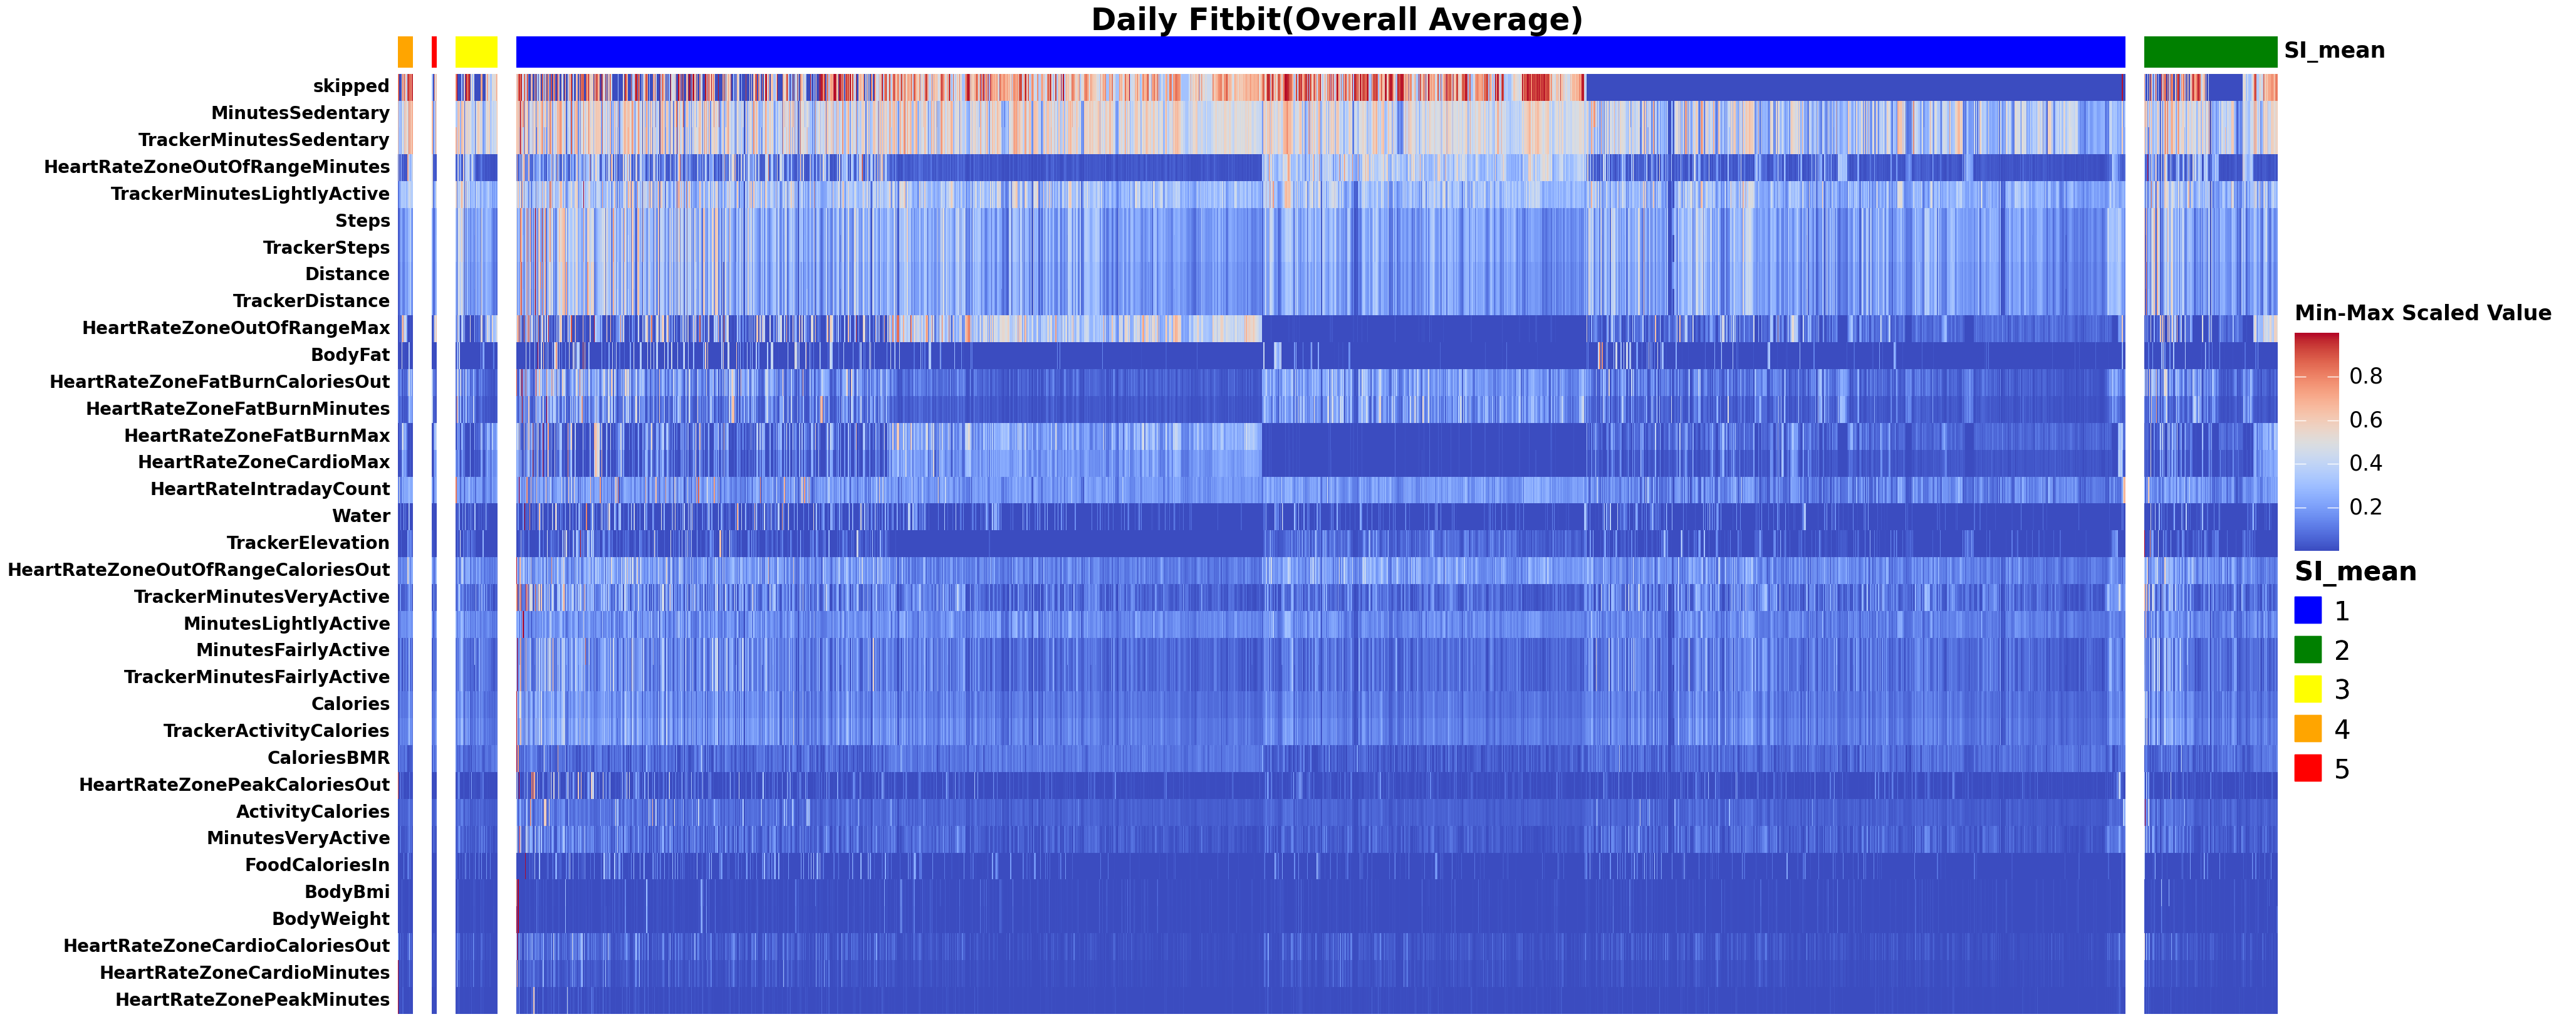

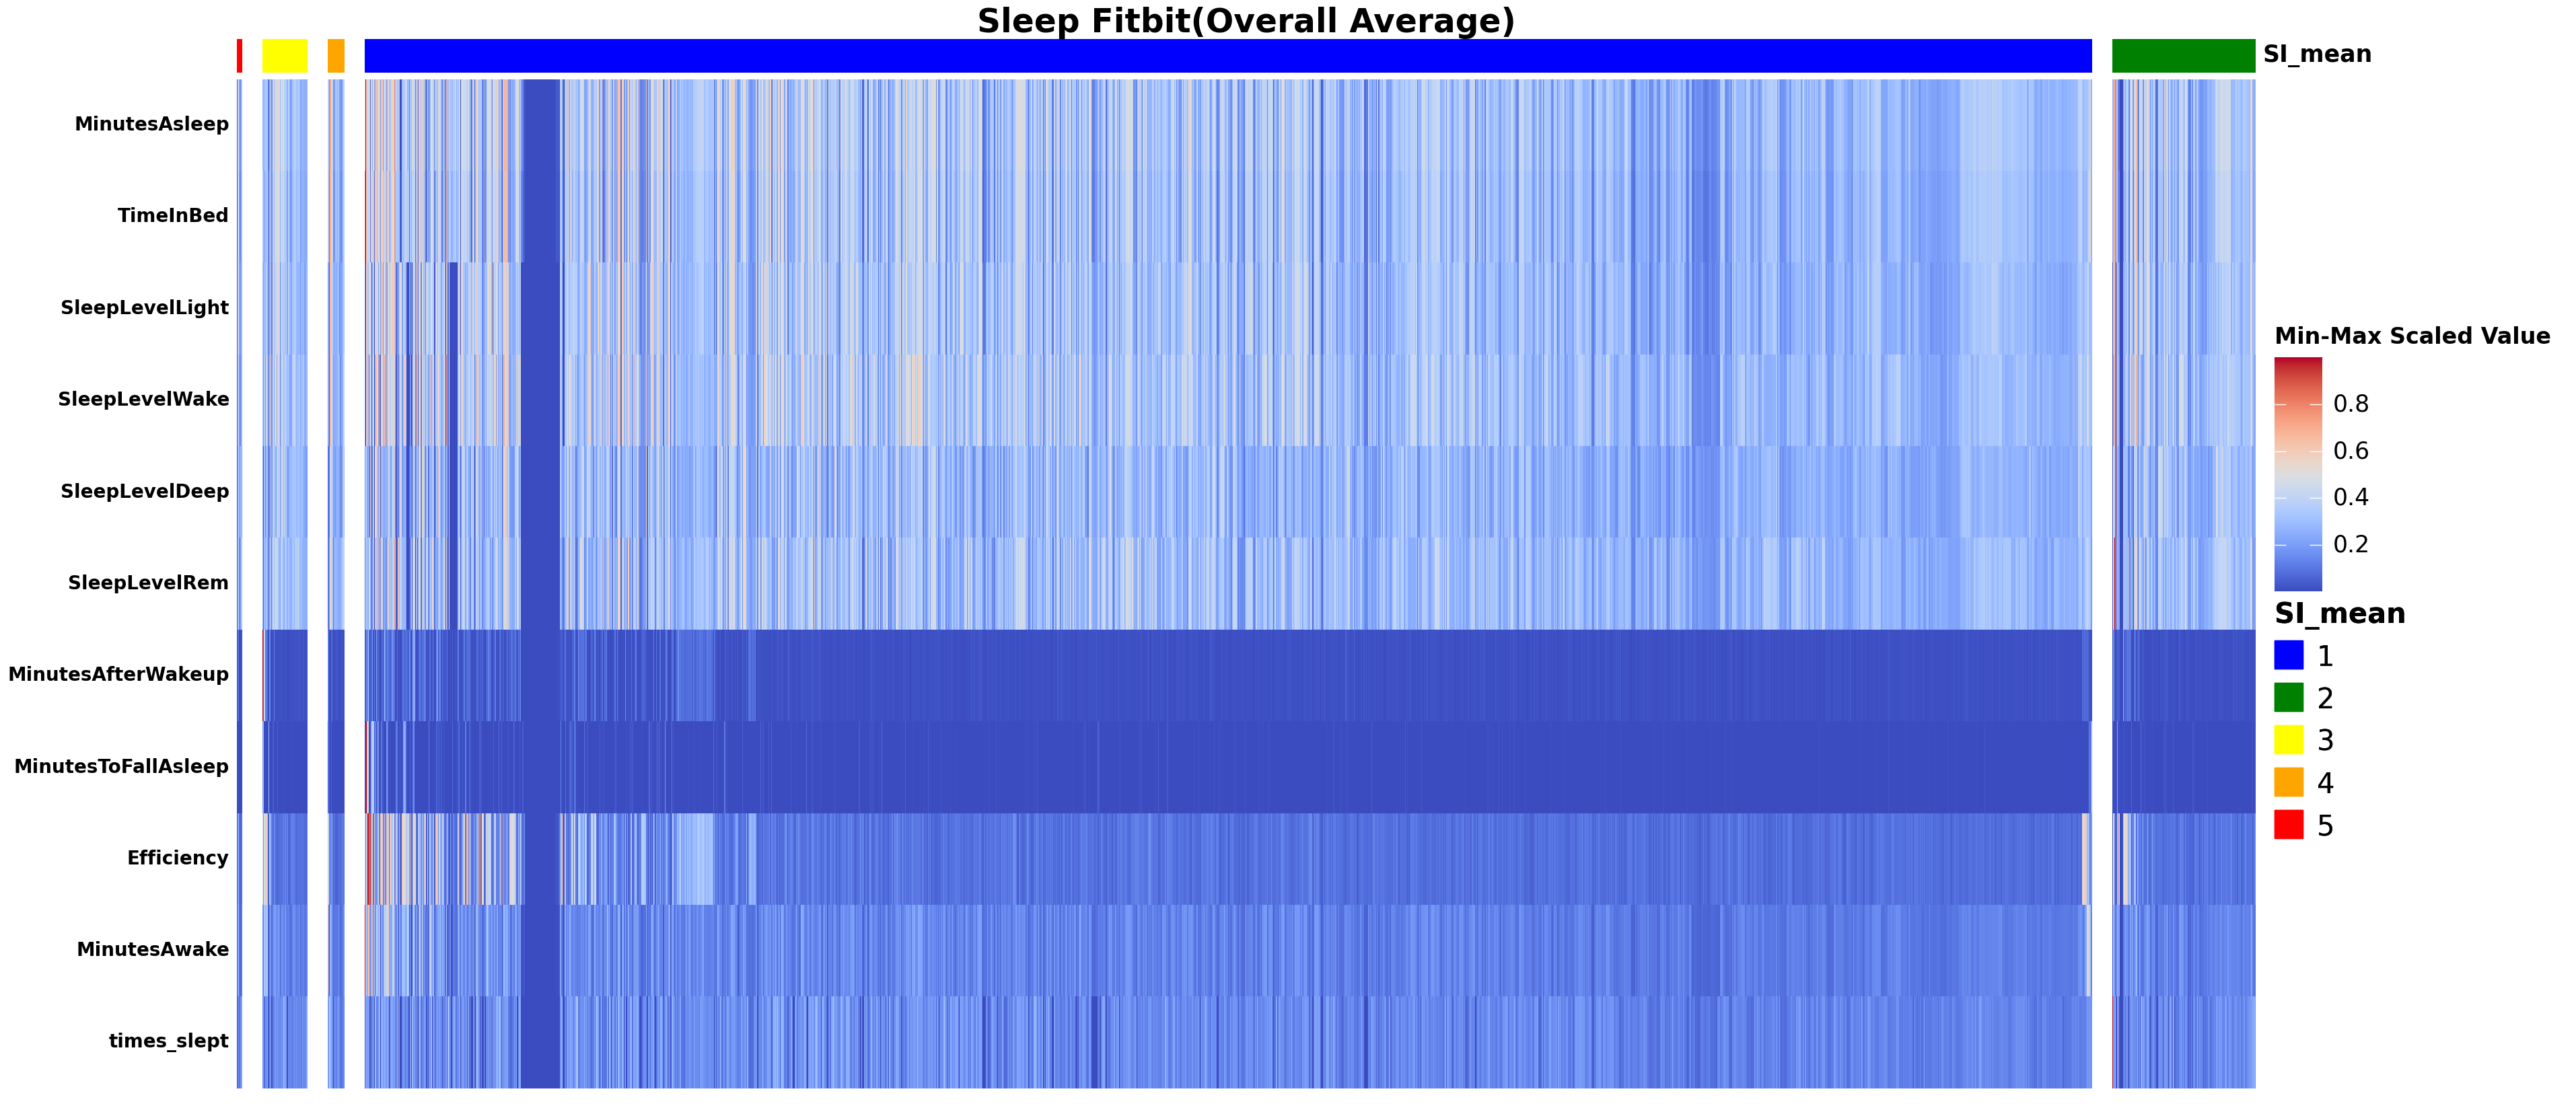

In [5]:
def time_series_dotplot(daily, sleep, survey):
    # Aggregate daily data (mean and standard deviation)
    daily_agg_mean = daily.drop(columns='Date').groupby("PatientID", as_index=False).mean().set_index("PatientID")
    daily_agg_sd = daily.drop(columns='Date').groupby("PatientID", as_index=False).std().set_index("PatientID")
    
    # Aggregate sleep data (mean and standard deviation)
    sleep_agg_mean = sleep.drop(columns='Date').groupby("PatientID", as_index=False).mean().set_index("PatientID")
    sleep_agg_sd = sleep.drop(columns='Date').groupby("PatientID", as_index=False).std().set_index("PatientID")
    
    # Prepare survey metadata and sort by SI_max and SI_mean
    survey_meta = survey[["PatientID", "SI_max", "SI_mean"]].sort_values(
        ["SI_max", "SI_mean"], ascending=False
    ).reset_index(drop=True)
    
#     # Reorder daily and sleep data by the order of PatientID in survey_meta
#     daily_agg_mean = daily_agg_mean.loc[survey_meta["PatientID"].to_list(), :]
#     sleep_agg_mean = sleep_agg_mean.loc[survey_meta["PatientID"].to_list(), :]
    
    daily_agg_mean = daily_agg_sd.loc[survey_meta["PatientID"].to_list(), :]
    sleep_agg_mean = sleep_agg_sd.loc[survey_meta["PatientID"].to_list(), :]
    
    # Apply min-max scaling to the aggregated DataFrames for mean
    daily_agg_mean_scaled = (daily_agg_mean - daily_agg_mean.min()) / (daily_agg_mean.max() - daily_agg_mean.min())
    sleep_agg_mean_scaled = (sleep_agg_mean - sleep_agg_mean.min()) / (sleep_agg_mean.max() - sleep_agg_mean.min())
    
    # Define spectral color palette for SI_max labels (as strings)
    si_colors = {
        "1": "#0000FF",  # blue
        "2": "#008000",  # green
        "3": "#FFFF00",  # yellow
        "4": "#FFA500",  # orange
        "5": "#FF0000"   # red
    }
    
    # Titles for the two plots
    titles = ["Daily Fitbit(Overall Average)", "Sleep Fitbit(Overall Average)"]
    
    # Loop over the two datasets: daily and sleep
    for i, df_mean in enumerate([daily_agg_mean_scaled, sleep_agg_mean_scaled]):
        # Transpose the DataFrame so that rows are features and columns are samples
        # Fill missing values with zero
        heatmap_data = df_mean.T.fillna(0).values
        
        # Create a Marsilea Heatmap
        h = ma.Heatmap(
            data=heatmap_data,
            center=0.5,
            height=15,
            width=30,
            cmap="coolwarm",
            label="standardized\n expression",
            cbar_kws={
                "title": "Min-Max Scaled Value",
                "title_fontproperties": {'size': 24, 'weight': 'bold'},  # Bold colorbar title
                "fontsize": 25,  # Tick label size for colorbar,
                
            }
        )
        
        # Add left labels for features (the original column names)
        features = list(df_mean.columns)
        feature_labels = mp.Labels(features, fontweight="bold", fontsize=20)
        h.add_left(feature_labels, pad=0.1)
        
        # Prepare top labels based on SI_max for each sample.
        # Since columns now correspond to samples (in the same order as survey_meta),
        # we use the SI_max values from survey_meta.
        #sample_si = survey_meta["SI_max"].astype(str).tolist()
        sample_si = survey_meta["SI_mean"].astype(int).astype(str).tolist()
        
        
        # Create a Colors component with increased legend font sizes.
        sample_colors = mp.Colors(
            sample_si,
            palette=si_colors,
            label="SI_mean",
            label_props={'fontsize': 25, 'fontweight': 'bold'},
            legend_kws={'fontsize': 30, 'title_fontproperties': {'size': 30, 'weight': 'bold'}}
        )
        

        # Add these as top components
        h.add_top(sample_colors, size=0.5, pad=0.1)
        h.group_cols(sample_si)
        h.add_dendrogram("top", show=False)
        h.add_dendrogram("right", show=False)
    
        
        h.add_legends()
        
    
        
        # Add a title to the plot
        h.add_title(top=titles[i], fontsize=35, fontweight="bold", pad=0.1)
        
        title = re.sub(" ", "_", titles[i])
        
        # Save plots:
#         h.save(f"../figures/EDA/{title}")
        
        

# Example usage:
time_series_dotplot(daily, sleep, survey)

In [13]:
def time_series_dotplot(daily, sleep, survey):
    # Aggregate daily data (mean and standard deviation)
    daily_agg_mean = daily.drop(columns='Date').groupby("PatientID", as_index=False).mean().set_index("PatientID")
    daily_agg_sd = daily.drop(columns='Date').groupby("PatientID", as_index=False).std().set_index("PatientID")
    daily_agg_max = daily.drop(columns='Date').groupby("PatientID", as_index=False).max().set_index("PatientID")
    daily_agg_min = daily.drop(columns='Date').groupby("PatientID", as_index=False).min().set_index("PatientID")

    # Aggregate sleep data (mean and standard deviation)
    sleep_agg_mean = sleep.drop(columns='Date').groupby("PatientID", as_index=False).mean().set_index("PatientID")
    sleep_agg_sd = sleep.drop(columns='Date').groupby("PatientID", as_index=False).std().set_index("PatientID")
    daily_agg_max = daily.drop(columns='Date').groupby("PatientID", as_index=False).max().set_index("PatientID")
    daily_agg_min = daily.drop(columns='Date').groupby("PatientID", as_index=False).min().set_index("PatientID")

    # Prepare survey metadata and sort by SI_max and SI_mean
    survey_meta = survey[["PatientID", "SI_max", "SI_mean"]].sort_values(
        ["SI_max", "SI_mean"], ascending=False
    ).reset_index(drop=True)

    # Reorder daily and sleep data by the order of PatientID in survey_meta
    daily_agg_mean = daily_agg_max.loc[survey_meta["PatientID"].to_list(), :]
    sleep_agg_mean = sleep_agg_max.loc[survey_meta["PatientID"].to_list(), :]

    # Apply min-max scaling to the aggregated DataFrames for mean
    daily_agg_mean_scaled = (daily_agg_mean - daily_agg_mean.min()) / (daily_agg_mean.max() - daily_agg_mean.min())
    sleep_agg_mean_scaled = (sleep_agg_mean - sleep_agg_mean.min()) / (sleep_agg_mean.max() - sleep_agg_mean.min())

    # Define spectral color palette for SI_max labels
    si_colors = {
        "1": "#0000FF",  # Blue
        "2": "#008000",  # Green
        "3": "#FFFF00",  # Yellow
        "4": "#FFA500",  # Orange
        "5": "#FF0000"   # Red
    }

    # Titles for the two plots
    titles = ["Daily Fitbit (Overall Average)", "Sleep Fitbit (Overall Average)"]

    # Loop over the two datasets: daily and sleep
    for i, df_mean in enumerate([daily_agg_mean_scaled, sleep_agg_mean_scaled]):
        # Transpose the DataFrame so that rows are features and columns are samples
        heatmap_data = df_mean.T.fillna(0)

        # Prepare SI_mean labels
        sample_si = survey_meta["SI_max"].astype(int).astype(str).tolist()

        # Perform hierarchical clustering within each SI_mean level
        reordered_indices = []
        for si_level in sorted(survey_meta["SI_mean"].unique()):
            level_indices = survey_meta.loc[survey_meta["SI_mean"] == si_level, "PatientID"].to_list()
            
            if len(level_indices) > 1:  # Only cluster if more than one patient exists in this level
                subset_data = heatmap_data[level_indices]  # Select only columns for this SI_mean level
                
                # Compute distance matrix and hierarchical clustering
                linkage_matrix = fastcluster.linkage(subset_data.T, method="ward")
                
                # Get ordering from hierarchical clustering
                cluster_order = sch.leaves_list(linkage_matrix)
                
                # Reorder indices within this SI level
                reordered_indices.extend([level_indices[i] for i in cluster_order])
            else:
                reordered_indices.append(level_indices[0])  # Keep single observations as is

        # Reorder heatmap data
        heatmap_data = heatmap_data[reordered_indices]

        # Create a Marsilea Heatmap
        h = ma.Heatmap(
            data=heatmap_data.values,
            center=0.5,
            height=15,
            width=30,
            cmap="coolwarm",
            label="standardized\n expression",
            cbar_kws={
                "title": "Min-Max Scaled Value",
                "title_fontproperties": {'size': 24, 'weight': 'bold'},  # Bold colorbar title
                "fontsize": 25,  # Tick label size for colorbar
            }
        )

        # Add left labels for features
        features = list(df_mean.columns)
        feature_labels = mp.Labels(features, fontweight="bold", fontsize=20)
        h.add_left(feature_labels, pad=0.1)

        # Create a Colors component for SI_mean levels
        sample_colors = mp.Colors(
            sample_si,
            palette=si_colors,
            label="SI_mean",
            label_props={'fontsize': 25, 'fontweight': 'bold'},
            legend_kws={'fontsize': 30, 'title_fontproperties': {'size': 30, 'weight': 'bold'}}
        )

        # Add SI_mean as top labels
        h.add_top(sample_colors, size=0.5, pad=0.1)
        h.group_cols(sample_si)
        h.add_dendrogram("right", show=False)

        h.add_legends()

        # Add a title to the plot
        h.add_title(top=titles[i], fontsize=35, fontweight="bold", pad=0.1)
        
        h.render()

# Example usage:
# time_series_dotplot(daily, sleep, survey)


In [3]:
def time_series_dotplot(daily, sleep, survey):
    # -------------------------------
    # 1. Aggregate the data
    # -------------------------------
    # Daily aggregations: mean, standard deviation, maximum, minimum
    daily_agg_mean = daily.drop(columns='Date').groupby("PatientID", as_index=False).mean().set_index("PatientID")
#     daily_agg_sd   = daily.drop(columns='Date').groupby("PatientID", as_index=False).std().set_index("PatientID")
#     daily_agg_max  = daily.drop(columns='Date').groupby("PatientID", as_index=False).max().set_index("PatientID")
#     daily_agg_min  = daily.drop(columns='Date').groupby("PatientID", as_index=False).min().set_index("PatientID")
    
    # Sleep aggregations: mean, standard deviation, maximum, minimum
    sleep_agg_mean = sleep.drop(columns='Date').groupby("PatientID", as_index=False).mean().set_index("PatientID")
#     sleep_agg_sd   = sleep.drop(columns='Date').groupby("PatientID", as_index=False).std().set_index("PatientID")
#     sleep_agg_max  = sleep.drop(columns='Date').groupby("PatientID", as_index=False).max().set_index("PatientID")
#     sleep_agg_min  = sleep.drop(columns='Date').groupby("PatientID", as_index=False).min().set_index("PatientID")
    
    # -------------------------------
    # 2. Prepare survey metadata
    # -------------------------------
    # Use survey columns "PatientID", "SI_max", "SI_mean"
    survey_meta = survey[["PatientID", "SI_max", "SI_mean"]].copy()

    # -------------------------------
    # 3. Create dictionary for looping
    # -------------------------------
    # Two groups: daily and sleep. For each, we have four measures.
    groups = {
        "daily": {
            "mean": daily_agg_mean,
            "sd":   daily_agg_sd,
            "max":  daily_agg_max,
            "min":  daily_agg_min
        },
        "sleep": {
            "mean": sleep_agg_mean,
            "sd":   sleep_agg_sd,
            "max":  sleep_agg_max,
            "min":  sleep_agg_min
        }
    }
    # Two sort orders:
    sort_orders = ["SI_mean", "SI_max"]
    
    # Define a spectral color palette for SI labels
    si_colors = {
        "1": "#0000FF",  # Blue
        "2": "#008000",  # Green
        "3": "#FFFF00",  # Yellow
        "4": "#FFA500",  # Orange
        "5": "#FF0000"   # Red
    }
    
    # -------------------------------
    # 4. Loop over groups, measures, and sort orders
    # -------------------------------
    for group_name, measures in groups.items():
        for measure_name, df in measures.items():
            # Apply min-max scaling to each aggregated DataFrame (scale columnwise)
            df_scaled = (df - df.min()) / (df.max() - df.min())
            
            for sort_order in sort_orders:
                # Sort survey metadata by the chosen sort order (descending)
                survey_sorted = survey_meta.sort_values(by=sort_order, ascending=False)
                
                # For each unique level of the sort order, perform hierarchical clustering to reorder the patients
                reordered_indices = []
                unique_levels = sorted(survey_sorted[sort_order].unique())
                for level in unique_levels:
                    level_patients = survey_sorted.loc[survey_sorted[sort_order] == level, "PatientID"].to_list()
                    if len(level_patients) > 1:
                        # Subset the scaled data for these patients
                        # Note: df_scaled is indexed by PatientID; we want to cluster them.
                        subset_data = df_scaled.loc[level_patients].T.fillna(0)
                        # Perform hierarchical clustering on the transposed subset (samples as columns)
                        linkage_matrix = fastcluster.linkage(subset_data.T, method="ward")
                        cluster_order = sch.leaves_list(linkage_matrix)
                        reordered = [level_patients[idx] for idx in cluster_order]
                        reordered_indices.extend(reordered)
                    else:
                        reordered_indices.extend(level_patients)
                
                # Reorder the aggregated data (df_scaled) by the new patient order
                df_ordered = df_scaled.loc[reordered_indices]
                # Transpose so that rows are features and columns are patients for the heatmap
                heatmap_data = df_ordered.T.fillna(0)
                
                # Prepare SI labels for each patient in the new order.
                # Use the sort_order value from survey_meta.
                survey_lookup = survey_meta.set_index("PatientID")
                sample_si = [str(int(survey_lookup.loc[pid, sort_order])) for pid in reordered_indices]
                
                # Create a title and file name for the plot
                title = f"{group_name.capitalize()}_{measure_name}_{sort_order}"
                
                # -------------------------------
                # 5. Create the heatmap using Marsilea
                # -------------------------------
                h = ma.Heatmap(
                    data=heatmap_data.values,
                    center=0.5,
                    height=15,
                    width=30,
                    cmap="coolwarm",
                    label="Min-Max Scaled Value",
                    cbar_kws={
                        "title": "Min-Max Scaled Value",
                        "title_fontproperties": {'size': 24, 'weight': 'bold'},
                        "fontsize": 25,
                    }
                )
                
                # Add left labels: list of features (the columns of df_ordered)
                features = list(df_ordered.columns)
                feature_labels = mp.Labels(features, fontweight="bold", fontsize=20)
                h.add_left(feature_labels, pad=0.1)
                
                # Create a Colors component for the SI labels using the selected sort order
                sample_colors = mp.Colors(
                    sample_si,
                    palette=si_colors,
                    label=sort_order,
                    label_props={'fontsize': 25, 'fontweight': 'bold'},
                    legend_kws={'fontsize': 30, 'title_fontproperties': {'size': 30, 'weight': 'bold'}}
                )
                h.add_top(sample_colors, size=0.5, pad=0.1)
                h.group_cols(sample_si)
                h.add_dendrogram("right", show=False)
                h.add_legends()
                h.add_title(top=title, fontsize=35, fontweight="bold", pad=0.1)
                
                # -------------------------------
                # 6. Save the plot with a filename corresponding to its parameters.
                # -------------------------------
                h.save(f"../figures/EDA/{title}.png")
                
# Example usage:
time_series_dotplot(daily, sleep, survey)


NameError: name 'daily_agg_sd' is not defined

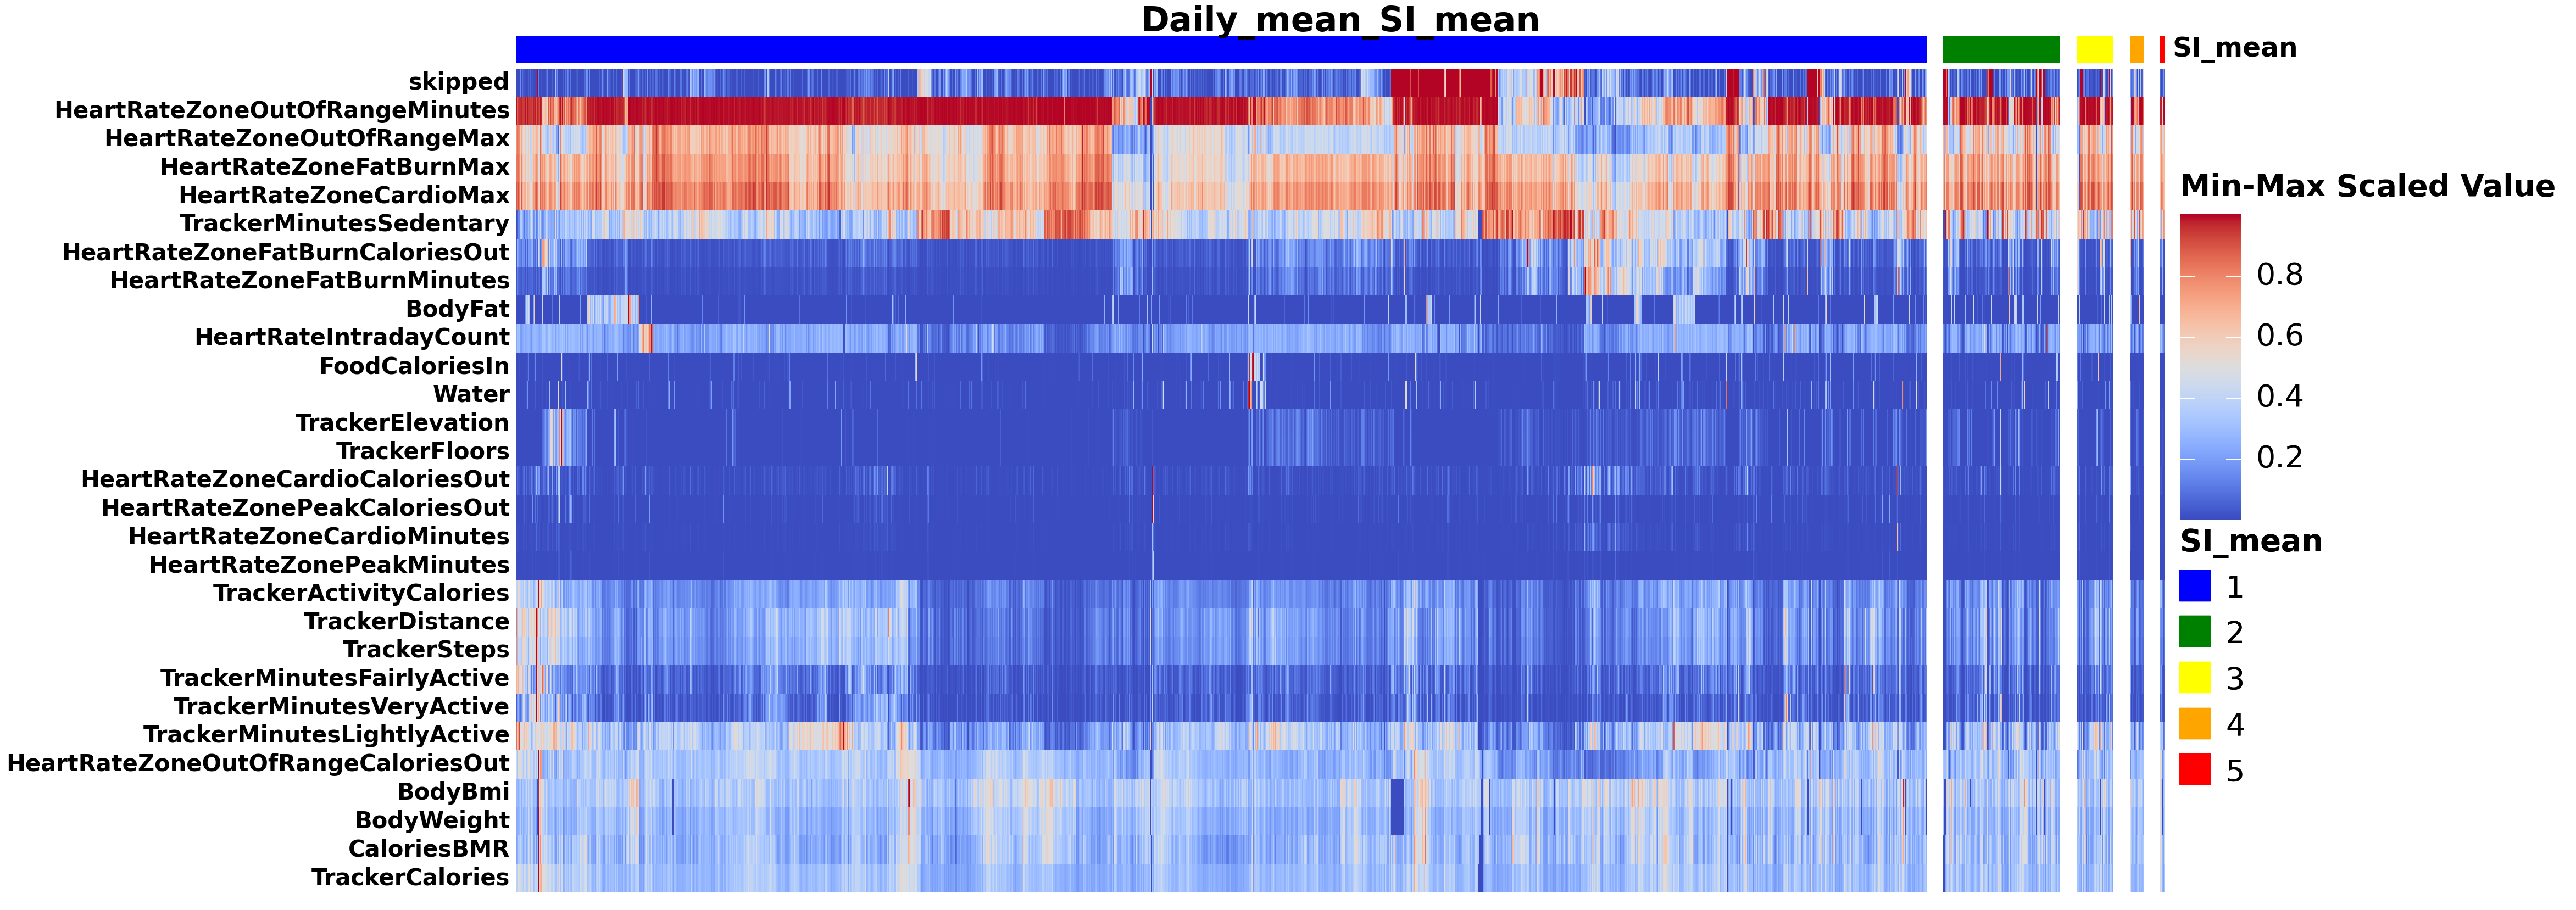

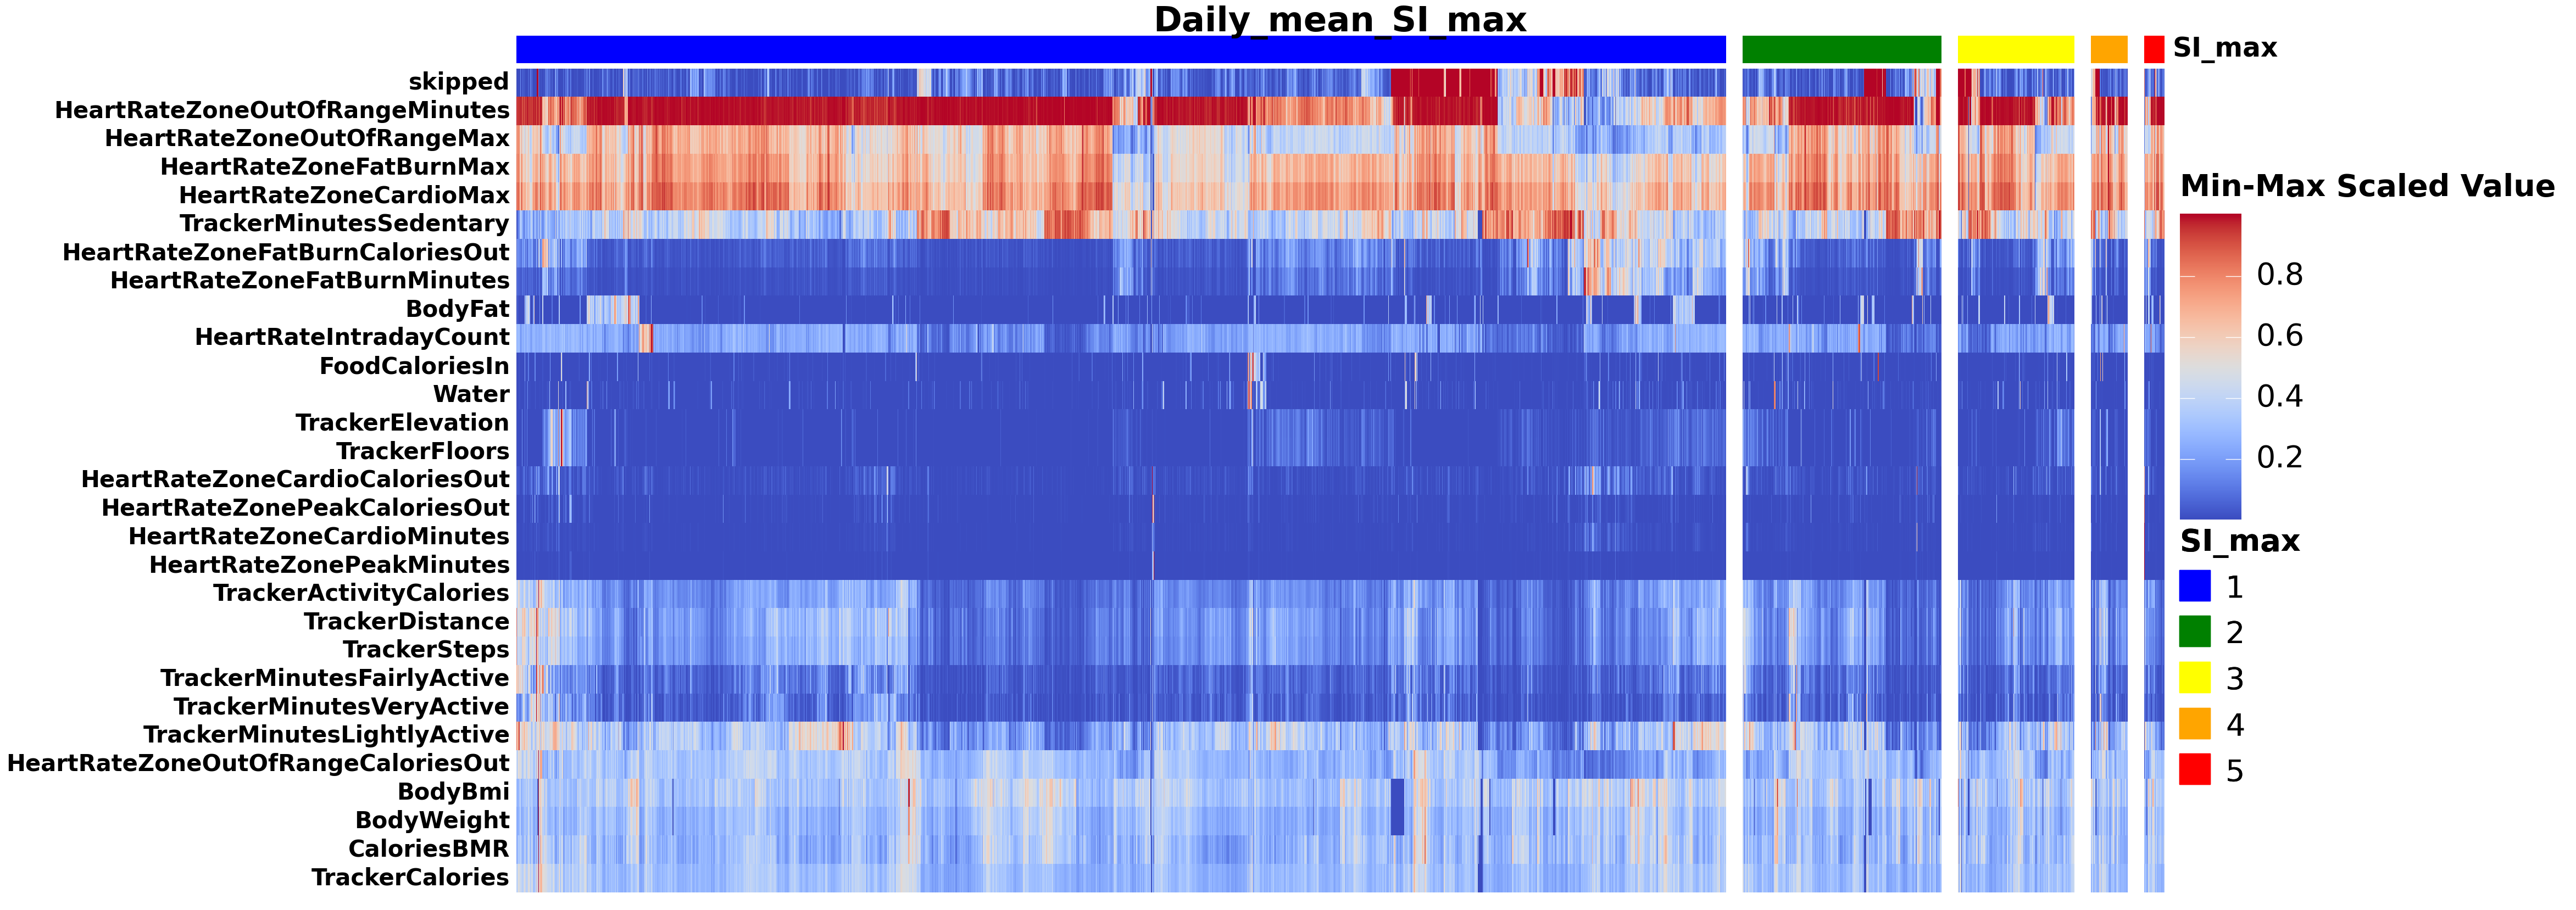

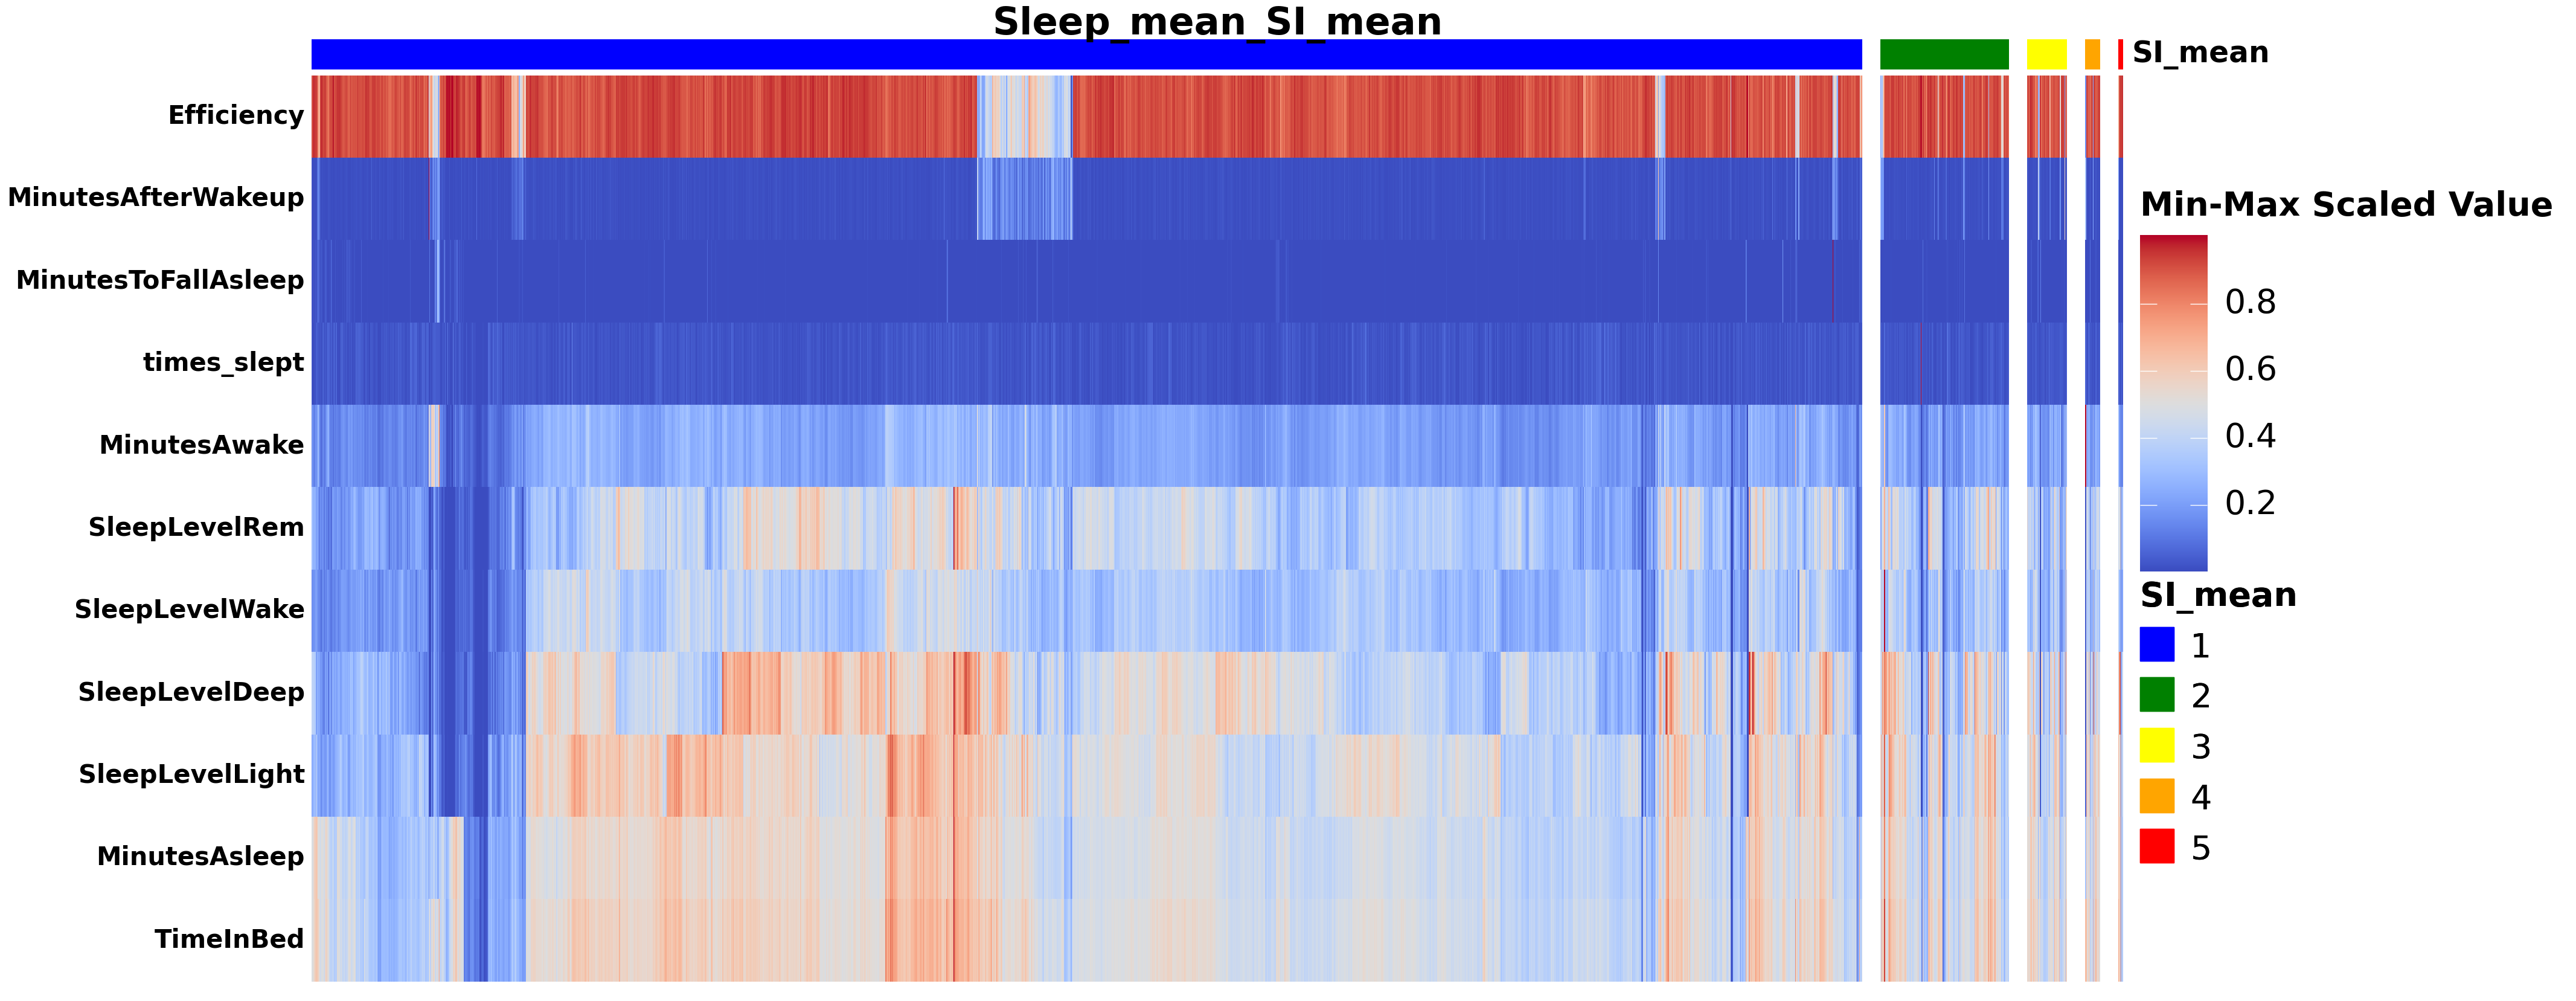

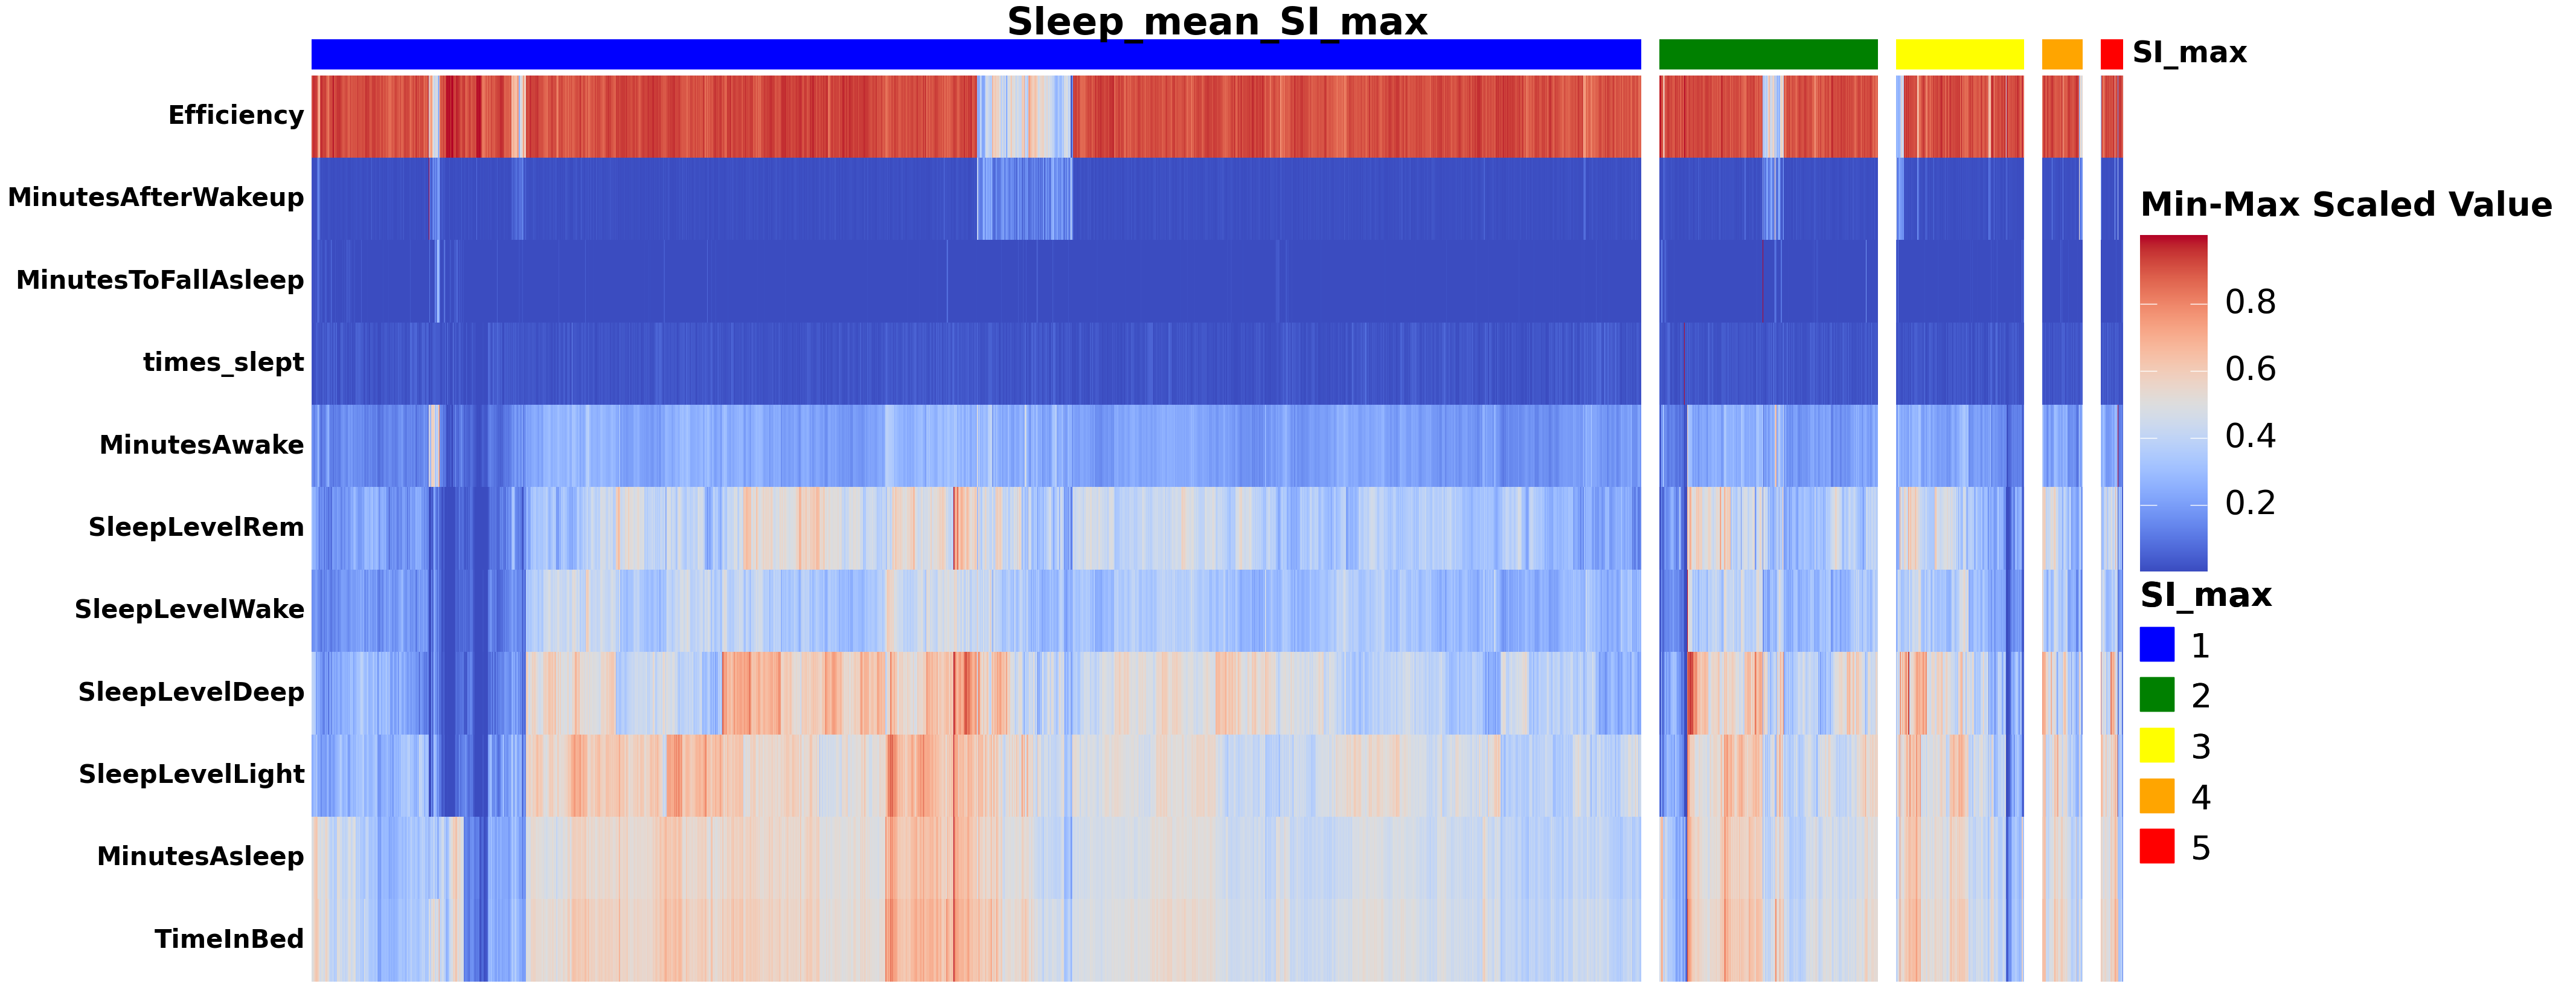

In [4]:
def time_series_dotplot(daily, sleep, survey):
    # -------------------------------
    # 1. Aggregate the data by mean only
    # -------------------------------
    daily_agg_mean = daily.drop(columns='Date').groupby("PatientID", as_index=False).mean().set_index("PatientID")
    sleep_agg_mean = sleep.drop(columns='Date').groupby("PatientID", as_index=False).mean().set_index("PatientID")
    
    # -------------------------------
    # 2. Prepare survey metadata
    # -------------------------------
    survey_meta = survey[["PatientID", "SI_mean"]].copy()
    
    # -------------------------------
    # 3. Create dictionary for looping (only mean)
    # -------------------------------
    groups = {
        "daily": {"mean": daily_agg_mean},
        "sleep": {"mean": sleep_agg_mean}
    }
    sort_orders = ["SI_mean", "SI_max"]
    
    # Define a spectral color palette for SI labels
    si_colors = {
        "1": "#0000FF",  # Blue
        "2": "#008000",  # Green
        "3": "#FFFF00",  # Yellow
        "4": "#FFA500",  # Orange
        "5": "#FF0000"   # Red
    }
    
    # -------------------------------
    # 4. Loop over groups, measures, and sort orders
    # -------------------------------
    for group_name, measures in groups.items():
        for measure_name, df in measures.items():
            # Apply min-max scaling to each aggregated DataFrame (scale columnwise)
            df_scaled = (df - df.min()) / (df.max() - df.min())
            
            for sort_order in sort_orders:
                # Sort survey metadata by the chosen sort order (descending)
                survey_sorted = survey_meta.sort_values(by=sort_order, ascending=False)
                
                # For each unique level of the sort order, perform hierarchical clustering to reorder the patients
                reordered_indices = []
                unique_levels = sorted(survey_sorted[sort_order].unique())
                for level in unique_levels:
                    level_patients = survey_sorted.loc[survey_sorted[sort_order] == level, "PatientID"].to_list()
                    if len(level_patients) > 1:
                        # Subset the scaled data for these patients and transpose so features are rows
                        subset_data = df_scaled.loc[level_patients].T.fillna(0)
                        # Perform hierarchical clustering on the transposed subset
                        linkage_matrix = fastcluster.linkage(subset_data.T, method="ward")
                        cluster_order = sch.leaves_list(linkage_matrix)
                        reordered = [level_patients[idx] for idx in cluster_order]
                        reordered_indices.extend(reordered)
                    else:
                        reordered_indices.extend(level_patients)
                
                # Reorder the aggregated data by the new patient order
                df_ordered = df_scaled.loc[reordered_indices]
                # Transpose so that rows are features and columns are patients for the heatmap
                heatmap_data = df_ordered.T.fillna(0)
                
                # Prepare SI labels for each patient in the new order using the sort_order value
                survey_lookup = survey_meta.set_index("PatientID")
                sample_si = [str(int(survey_lookup.loc[pid, sort_order])) for pid in reordered_indices]
                
                # Create a title for the plot
                title = f"{group_name.capitalize()}_{measure_name}_{sort_order}"
                
                # -------------------------------
                # 5. Create the heatmap using Marsilea with increased font sizes
                # -------------------------------
                h = ma.Heatmap(
                    data=heatmap_data.values,
                    center=0.5,
                    height=15,
                    width=30,
                    cmap="coolwarm",
                    label="Min-Max Scaled Value",
                    cbar_kws={
                        "title": "Min-Max Scaled Value",
                        "title_fontproperties": {'size': 40, 'weight': 'bold'},  # Increased legend title font size
                        "fontsize": 40,  # Increased legend tick font size
                    }
                )
                
                # Add left labels: list of features (the columns of df_ordered)
                features = list(df_ordered.columns)
                # Increase row labels' font size (changed from 20 to 30)
                feature_labels = mp.Labels(features, fontweight="bold", fontsize=30)
                h.add_left(feature_labels, pad=0.1)
                
                # Create a Colors component for the SI labels using the selected sort order
                # Increase top annotation label size (changed from fontsize 25 to 35)
                sample_colors = mp.Colors(
                    sample_si,
                    palette=si_colors,
                    label=sort_order,
                    label_props={'fontsize': 35, 'fontweight': 'bold'},
                    legend_kws={'fontsize': 40, 'title_fontproperties': {'size': 40, 'weight': 'bold'}}  # Increased legend size
                )
                h.add_top(sample_colors, size=0.5, pad=0.1)
                h.group_cols(sample_si)
                h.add_dendrogram("right", show=False)
                h.add_legends()
                # Increase the title font size (changed from 35 to 45)
                h.add_title(top=title, fontsize=45, fontweight="bold", pad=0.1)
                
                # -------------------------------
                # 6. Save the plot with a filename corresponding to its parameters.
                # -------------------------------
                
                h.render()
#                 h.save(f"../figures/EDA/{title}.png")
                
# Example usage:
time_series_dotplot(daily, sleep, survey)